In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_context('talk')

In [ ]:
class Vector(object):

    def __init__(self, xy):
        # xy = [[x,y], [tail,head]]
        self.x = xy[:, 0]
        self.y = xy[:, 1]
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        self.len = np.sqrt(self.dx**2 + self.dy**2)
#         print('dx: ', self.dx)
#         print('dy: ', self.dy)
#         print('len: ', self.len)


class MachCone(object):

    def __init__(self, tau, e1, e2, ref_state):
        gamma = 5.0 / 3.0
        self.tau = tau
        self.rho_tilde = ref_state[0]
        self.p_tilde = ref_state[3]
        self.u_tilde = ref_state[1]
        self.v_tilde = ref_state[2]
        self.a_tilde = np.sqrt(gamma * self.p_tilde / self.rho_tilde)
        self.radius = self.tau * self.a_tilde
        self.p_xy = e1[0]
        self.p_prime_xy = [
            self.p_xy[0] - self.u_tilde * self.tau,
            self.p_xy[1] - self.v_tilde * self.tau,
        ]
        self.e1 = e1  # [[x,y], [tail,head]]
        self.e2 = e2
        v1 = Vector(e1)
        v2 = Vector(e2)

        self.sin_alpha = np.array([v1.dy / v1.len, v2.dy / v2.len])
        self.cos_alpha = np.array([v1.dx / v1.len, v2.dx / v2.len])
#         self.sin_alpha = np.array([v1.dy, v2.dy])
#         self.cos_alpha = np.array([v1.dx, v2.dx])

        self.b_k = np.abs(self.u_tilde * self.cos_alpha - self.v_tilde*self.sin_alpha)
        print('b_k:', self.b_k, 'a:', self.a_tilde)
        
        self.calc_lk()
        self.calc_theta_kl()
        
        
        print('sin(alpha): ', self.sin_alpha)
        print('cos(alpha): ', self.cos_alpha)
        print('l_k: ', self.l_k)
        
        self.calc_intersections()
        self.calc_arc_thetas()
        print('n_k:', self.n_intersections)
        print('theta_ib:', np.rad2deg(self.theta_ib))
        print('theta_ie:', np.rad2deg(self.theta_ie))
        
    def calc_lk(self):
        self.l_k = np.zeros([2, 2])
        for i in range(2):

            self.l_k[i, 0] = -self.tau * (
                self.u_tilde * self.cos_alpha[i] +
                self.v_tilde * self.sin_alpha[i]
            ) - self.tau * np.sqrt(self.a_tilde**2 -
                                   (self.u_tilde * self.cos_alpha[i] -
                                    self.v_tilde * self.sin_alpha[i])**2)
            self.l_k[i, 1] = -self.tau * (
                self.u_tilde * self.cos_alpha[i] +
                self.v_tilde * self.sin_alpha[i]
            ) + self.tau * np.sqrt(self.a_tilde**2 +
                                   (self.u_tilde * self.cos_alpha[i] -
                                    self.v_tilde * self.sin_alpha[i])**2)

    def calc_theta_kl(self):
        self.theta_kl = np.zeros([2, 2])
        for k in range(2):
            for l in range(2):
                cos_alpha_kl = (self.u_tilde + self.l_k[k, l] * self.cos_alpha[k]) / self.a_tilde
                sin_alpha_kl = (self.v_tilde + self.l_k[k, l] * self.sin_alpha[k]) / self.a_tilde
                self.theta_kl[k, l] = np.pi + np.sign(sin_alpha_kl) * (np.arccos(cos_alpha_kl) - np.pi)
                print(f'theta_kl: {np.rad2deg(self.theta_kl[k, l]):.2f}, {np.rad2deg(self.theta_kl[k, l]):.2f}')
        
    def calc_intersections(self):
        self.n_intersections = np.zeros(2)
        for k in range(2):
            if (self.b_k[k] > self.a_tilde) or (self.l_k[k, 0] <= self.l_k[k,1] < 0):
                self.n_intersections[k] = 0
            elif (self.l_k[k,1] >= 0) and (self.l_k[k,0] < 0):
                self.n_intersections[k] = 1
            else:
                self.n_intersections[k] = 2
        
    def calc_arc_thetas(self):
        theta_ib = np.zeros([2,2])
        theta_ie = np.zeros([2,2])
        theta11 = self.theta_kl[0,0]
        theta12 = self.theta_kl[0,1]
        theta21 = self.theta_kl[1,0]
        theta22 = self.theta_kl[1,1]
        
        n1 = self.n_intersections[0]
        n2 = self.n_intersections[1]
        
        if n1 == n2 == 1:
            theta_ib[:,:] = theta12
            if theta22 >= theta12:
                theta_ie[:,:] = theta22
            else:
                theta_ie[:,:] = theta22 + 2*np.pi
                
        self.theta_ib = theta_ib
        self.theta_ie = theta_ie
        
    def plot(self):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_aspect("equal")
        plt.plot(self.p_xy[0], self.p_xy[1], "o", label="P")
        plt.plot(self.p_prime_xy[0], self.p_prime_xy[1], "o", label="p'")

#         edge1 = plt.arrow(
#             x=self.p_xy[0],
#             y=self.p_xy[1],
#             dx=self.e1[1, 0] - self.e1[0, 0],
#             dy=self.e1[1, 1] - self.e1[0, 1],
#             width=0.0025,
#             label="edge 1",
#         )
        
        plt.plot(self.e1[0,:], self.e1[1,:])
        plt.plot(self.e2[0,:], self.e2[1,:])
        
#         edge2 = plt.arrow(
#             x=self.p_xy[0],
#             y=self.p_xy[1],
#             dx=self.e2[1, 0] - self.e2[0, 0],
#             dy=self.e2[1, 1] - self.e2[0, 1],
#             width=0.0025,
#             label="edge 2",
#         )

        circle = plt.Circle(self.p_prime_xy, self.radius, color="grey", fill=False)
        ax.add_artist(circle)
        minn = np.min([self.e1, self.e2])
        maxx = np.max([self.e1, self.e2])
        plt.xlim(minn,maxx)
        plt.ylim(minn,maxx)
        plt.legend()
        plt.grid()
        plt.show()

# tau = .1

e1 = np.array([[0, 0], [-1, 0]])
e2 = np.array([[0, 0], [1, 0]])
cone0 = MachCone(tau=tau,
                e1=e2,
                e2=e1,
                ref_state=np.array([1.0, .6, 2.0, 8.0]))

cone0.plot()

# e1 = np.array([[0, 0], [1, .7]])
# e2 = np.array([[0, 0], [.2, 1.0]])
# cone1 = MachCone(tau=.01,
#                 e1=e1,
#                 e2=e2,
#                 ref_state=np.array([1.0, .6, 2.0, 8.0]))

# cone1.plot()

In [ ]:
e1 = np.array([[0, 0], [0,  0.02]])
e2 = np.array([[0, 0], [0, -0.02]])
cone1 = MachCone(tau=.001,
                e1=e1,
                e2=e2,
                ref_state=np.array([1.400, 1.000, .998, 4.000]))

cone1.plot()

In [ ]:
e1 = np.array([[-1.000, -.980], [-1.000, -1.000]])
e2 = np.array([[-1.000, -.980], [-1.000, -.960]])
cone1 = MachCone(tau=1e-6,
                e1=e1,
                e2=e2,
                ref_state=np.array([1.400, -1.000, .998, 4.000]))

cone1.plot()

In [ ]:
x = [.2,.8,.9,.3]; x.append(x[0])
y = [.2,.2,.8,.8]; y.append(y[0])

quad = np.array([x,y])

circle = plt.Circle((0.5, 0.5), 0.2, color='grey', fill=False)

fig, ax = plt.subplots(figsize=(8,8))
edge1 = plt.arrow(x=0,y=0,dx=.5,dy=.5, width=.0025, color='k')

plt.plot(quad[0,:],quad[1,:])
plt.grid(True)
ax.add_artist(circle)
ax.add_artist(edge1)
plt.show()

In [16]:
class Vector(object):

    def __init__(self, xy1, xy2):
        self.x = np.array([xy1[0],xy2[0]])
        self.y = np.array([xy1[1],xy2[1]])
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        self.len = np.sqrt(self.dx**2 + self.dy**2)

def vector_circle_intersection(vec_xy, circle_xy, radius):

    x0 = vec_xy[0, 0]
    y0 = vec_xy[0, 1]
    x1 = vec_xy[1, 0]
    y1 = vec_xy[1, 1]
    r = radius
    h = circle_xy[0]
    k = circle_xy[1]

    a = (x1 - x0)**2 + (y1 - y0)**2
    b = 2 * (x1 - x0) * (x0 - h) + 2 * (y1 - y0) * (y0 - k)
    c = (x0 - h)**2 + (y0 - k)**2 - r**2

    discr = b**2 - 4 * a * c
#     print('disc', discr)
#     print('c', c)
    t = np.zeros(2)
    
    if discr > 0:
        if ((-b - np.sqrt(discr))==0):
            t[1] = 1.0
        else:
            t[1] = (2 * c) / (-b - np.sqrt(discr))
    
        if ((-b + np.sqrt(discr))==0):
            t[0] = 0.0
        else:
            t[0] = (2 * c) / (-b + np.sqrt(discr))

#     print('0', -b - np.sqrt(discr))
#     print('1', -b + np.sqrt(discr))
#     print('t',t)

    n_intersections = np.array([False, False])
    for i in range(2):
        if 0 < t[i] <= 1:
            n_intersections[i] = True

    x_t = (x1 - x0) * t + x0
    y_t = (y1 - y0) * t + y0

    for t_i in t:
        plt.plot(x_t, y_t, 's', color='k', markerfacecolor='none')

    plt.plot(x0, y0, 'o', label='0')
    plt.plot(x1, y1, 'o', label='1')
    plt.plot([x0, x1], [y0, y1], 'k')

    theta = np.linspace(0, 2 * np.pi, 100)
    X = r * np.cos(theta) + h
    Y = r * np.sin(theta) + k
    plt.plot(X, Y)
    plt.plot(h,k,'x')
    plt.xlim(np.min([X,Y]), np.max([X,Y]))
    plt.ylim(np.min([X,Y]), np.max([X,Y]))
    plt.legend()
    plt.gca().set_aspect("equal")
    plt.show()
    return np.array([[x_t[0], y_t[0]], [x_t[1], y_t[1]]]), n_intersections

def intersection_angle(circle_origin_xy, intersection_xy):
    angle = np.zeros(2)
    dx0 = intersection_xy[0,0] - circle_origin_xy[0]
    dx1 = intersection_xy[1,0] - circle_origin_xy[0]
    dy0 = intersection_xy[0,1] - circle_origin_xy[1]
    dy1 = intersection_xy[1,1] - circle_origin_xy[1]
    print(dx0,dy0,dx1,dy1)
#     angle_deg[0] = np.rad2deg(np.arctan2(dy0, dx0))
#     angle_deg[1] = np.rad2deg(np.arctan2(dy1, dx1))
#     for i in range(2):
#         if angle_deg[i] < 0: angle_deg[i] += 360 
#     return angle_deg

    angle[0] = np.arctan2(dy0, dx0)
    angle[1] = np.arctan2(dy1, dx1)
#     for i in range(2):
#         if angle[i] < 0: angle[i] += 2*np.pi
    return angle

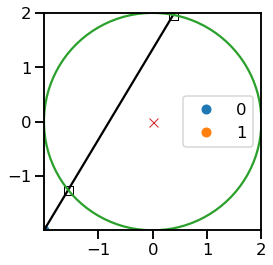

-1.5548045132444108 -1.2580075220740181 0.3783339250091169 1.9638898750151945


array([3.8218637, 1.3804826])

In [3]:
h=0;k=0
P_prime_xy = [h, k]
vec_xy = np.array([[-2+h, -2+k], [1+h, 3+k]])
vci = vector_circle_intersection(vec_xy, circle_xy=P_prime_xy, radius=2)
intersection_angle(circle_origin_xy=P_prime_xy, intersection_xy=vci[0]) 

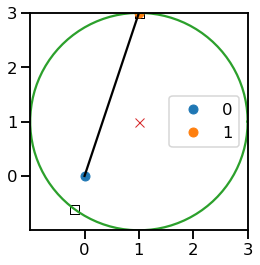

-1.2 -1.6 0.0 2.0
angles [-126.86989765   90.        ]
angles [-2.2142974356 1.5707963268]


In [17]:
P_prime_xy = [ 1.0, 1.0]
vec_xy = np.array([[0, 0], [1, 3]])
vci = vector_circle_intersection(vec_xy,
                                 circle_xy=P_prime_xy,
                                 radius=2.0)
angles = intersection_angle(circle_origin_xy=P_prime_xy, intersection_xy=vci[0])
print('angles', np.rad2deg(angles))
print(f'angles [{angles[0]:.10f} {angles[1]:.10f}]')


## Midpoint

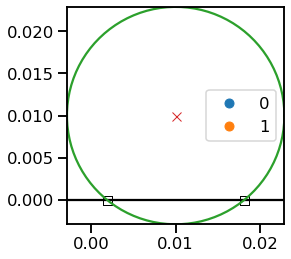

-0.008164965809276828 -0.01 0.008164965809276845 -0.01
angles [-129.23152048  -50.76847952]
angles [-2.2555155298 -0.8860771238]


In [18]:
P_prime_xy = [ 0.01, 0.01]
vec_xy = np.array([[-1, 0], [1, 0]])
vci = vector_circle_intersection(vec_xy,
                                 circle_xy=P_prime_xy,
                                 radius=1.2909944487358056E-002)
angles = intersection_angle(circle_origin_xy=P_prime_xy, intersection_xy=vci[0])
print('angles', np.rad2deg(angles))
print(f'angles [{angles[0]:.10f} {angles[1]:.10f}]')

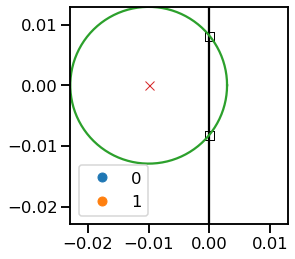

0.01 -0.008164965809276836 0.01 0.008164965809276836
angles [-39.23152048  39.23152048]
angles [-0.6847192030 0.6847192030]


In [21]:
P_prime_xy = [ -0.01, 0.0]
vec_xy = np.array([[0, -1], [0, 1]])
vci = vector_circle_intersection(vec_xy,
                                 circle_xy=P_prime_xy,
                                 radius=1.2909944487358056E-002)
angles = intersection_angle(circle_origin_xy=P_prime_xy, intersection_xy=vci[0])
print('angles', np.rad2deg(angles))
print(f'angles [{angles[0]:.10f} {angles[1]:.10f}]')

## Corner

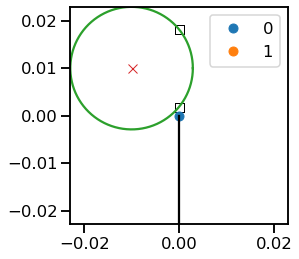

0.01 0.008164965809277258 0.01 -0.00816496580927726
angles [ 39.23152048 -39.23152048]
angles [0.6847192030 -0.6847192030]


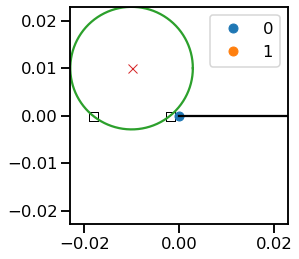

-0.008164965809277258 -0.01 0.00816496580927726 -0.01
angles [-129.23152048  -50.76847952]
angles [-2.2555155298 -0.8860771238]


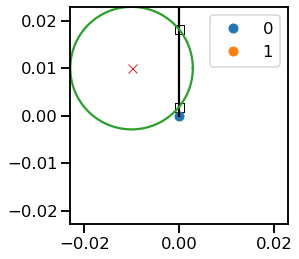

0.01 -0.00816496580927726 0.01 0.008164965809277258
angles [-39.23152048  39.23152048]
angles [-0.6847192030 0.6847192030]


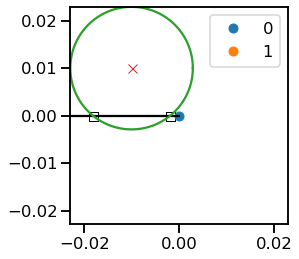

0.00816496580927726 -0.01 -0.008164965809277258 -0.01
angles [ -50.76847952 -129.23152048]
angles [-0.8860771238 -2.2555155298]


In [30]:
P_prime_xy = [ -0.01, 0.01]

vec_xy = np.array([[0, 0], [0, -1]])
vci = vector_circle_intersection(vec_xy,
                                 circle_xy=P_prime_xy,
                                 radius=1.2909944487358056E-002)
angles = intersection_angle(circle_origin_xy=P_prime_xy, intersection_xy=vci[0])
print('angles', np.rad2deg(angles))
print(f'angles [{angles[0]:.10f} {angles[1]:.10f}]')

vec_xy = np.array([[0, 0], [1, 0]])
vci = vector_circle_intersection(vec_xy,
                                 circle_xy=P_prime_xy,
                                 radius=1.2909944487358056E-002)
angles = intersection_angle(circle_origin_xy=P_prime_xy, intersection_xy=vci[0])
print('angles', np.rad2deg(angles))
print(f'angles [{angles[0]:.10f} {angles[1]:.10f}]')

vec_xy = np.array([[0, 0], [0, 1]])
vci = vector_circle_intersection(vec_xy,
                                 circle_xy=P_prime_xy,
                                 radius=1.2909944487358056E-002)
angles = intersection_angle(circle_origin_xy=P_prime_xy, intersection_xy=vci[0])
print('angles', np.rad2deg(angles))
print(f'angles [{angles[0]:.10f} {angles[1]:.10f}]')

vec_xy = np.array([[0, 0], [-1, 0]])
vci = vector_circle_intersection(vec_xy,
                                 circle_xy=P_prime_xy,
                                 radius=1.2909944487358056E-002)
angles = intersection_angle(circle_origin_xy=P_prime_xy, intersection_xy=vci[0])
print('angles', np.rad2deg(angles))
print(f'angles [{angles[0]:.10f} {angles[1]:.10f}]')

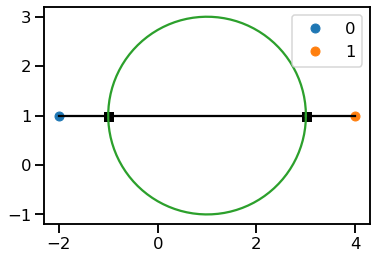

-2.0 0.0 2.0 0.0
[[-1.  1.]
 [ 3.  1.]]
[3.14159265 0.        ]


In [43]:
P_prime_xy = [1, 1]
vec_xy = np.array([[-2, 1], [4, 1]])
vci = vector_circle_intersection(vec_xy, circle_xy=P_prime_xy, radius=2)
angles = intersection_angle(circle_origin_xy=P_prime_xy, intersection_xy=vci[0])
print(vci[0])
print(angles)

In [12]:
theta_ie = 4.0276697774
theta_ib = 3.8263118566
print(np.sin(theta_ie) - np.sin(theta_ib))
print(np.sin(theta_ib) - np.sin(theta_ie))
print()
print(np.cos(theta_ie) - np.cos(theta_ib))
print(np.cos(theta_ib) - np.cos(theta_ie))
print()
print(theta_ie - theta_ib)
print(theta_ib - theta_ie)

-0.14214113721279653
0.14214113721279653

0.14214113721642352
-0.14214113721642352

0.20135792080000003
-0.20135792080000003


In [ ]:
P_prime_xy = [1, 1]
vec_xy = np.array([[0, 0], [1, 3]])
vci = vector_circle_intersection(vec_xy, circle_xy=P_prime_xy, radius=2)
print(vci)
v1 = Vector(xy1=P_prime_xy, xy2=vci[1]) # xy = [[x,y], [tail,head]]
print('angle', np.rad2deg(np.arccos(v1.dx/v1.len)))
v2 = Vector(xy1=P_prime_xy, xy2=vci[2]) # xy = [[x,y], [tail,head]]
print('angle', np.rad2deg(np.arccos(v2.dx/v2.len)))

In [ ]:
P_prime_xy = [1, 1]
vec_xy = np.array([[0, 1], [4, 1]])
vci = vector_circle_intersection(vec_xy, circle_xy=P_prime_xy, radius=2)
print(vci)
v1 = Vector(xy1=P_prime_xy, xy2=vci[1]) # xy = [[x,y], [tail,head]]
print('angle', np.rad2deg(np.arccos(v1.dx/v1.len)))
v2 = Vector(xy1=P_prime_xy, xy2=vci[2]) # xy = [[x,y], [tail,head]]
print('angle', np.rad2deg(np.arccos(v2.dx/v2.len)))

In [49]:
ie = np.deg2rad(95)
ie2 = ie + 2*np.pi
ib = np.deg2rad(185)
# if ie < ib:
#     ie = ie + 2*np.pi
(ie-ib)

-1.5707963267948963

In [54]:
print(np.cos(2*ie) - np.cos(2*ib))
print(np.cos(2*ie2) - np.cos(2*ib))

print(np.sin(2*ie) - np.sin(2*ib))
print(np.sin(2*ie2) - np.sin(2*ib))


print(np.cos(ie) - np.cos(ib))
print(np.cos(ie2) - np.cos(ib))

print(np.sin(ie) - np.sin(ib))
print(np.sin(ie2) - np.sin(ib))

-1.9696155060244163
-1.9696155060244163
-0.3472963553338604
-0.3472963553338595
0.9090389553440873
0.9090389553440877
1.0833504408394035
1.0833504408394035


## Slope Limiter

In [31]:
def limit(a,b):
    return np.max(a*b,0)*(a+b)/(a**2 + b**2)

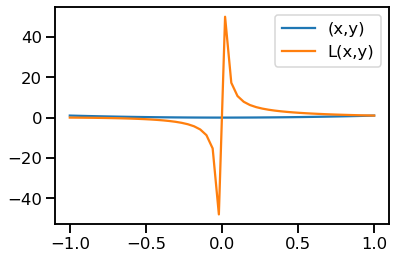

In [50]:
x = np.linspace(-1,1)
# y = np.linspace(-1,1)
y = x**2
plt.plot(x,y, label='(x,y)')
plt.plot(x,limit(x,y), label='L(x,y)')
plt.legend()
plt.show()

In [39]:
limit(a,a)

array([ -1.        ,  -1.04255319,  -1.08888889,  -1.13953488,
        -1.19512195,  -1.25641026,  -1.32432432,  -1.4       ,
        -1.48484848,  -1.58064516,  -1.68965517,  -1.81481481,
        -1.96      ,  -2.13043478,  -2.33333333,  -2.57894737,
        -2.88235294,  -3.26666667,  -3.76923077,  -4.45454545,
        -5.44444444,  -7.        ,  -9.8       , -16.33333333,
       -49.        ,  49.        ,  16.33333333,   9.8       ,
         7.        ,   5.44444444,   4.45454545,   3.76923077,
         3.26666667,   2.88235294,   2.57894737,   2.33333333,
         2.13043478,   1.96      ,   1.81481481,   1.68965517,
         1.58064516,   1.48484848,   1.4       ,   1.32432432,
         1.25641026,   1.19512195,   1.13953488,   1.08888889,
         1.04255319,   1.        ])